In [1]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares

In [2]:
GHz = 1e3 * 2 * jnp.pi
MHz = 1 * 2 * jnp.pi
kHz = 1e-3 * 2 * jnp.pi
Hz = 1e-6 * 2 * jnp.pi
us = 1

In [3]:
Na, Nb = 20, 5

kappa_a = 5 * kHz
kappa_b = 30 * MHz
g2 = 1.5 * MHz
alpha_m_2 = 5
epsilon_d = alpha_m_2 * g2
kerr = 14 * kHz

kappa_2 = 4 * g2**2 / kappa_b

delta_a = jnp.linspace(-1, 1, 41) * 3.5 * MHz
delta_b = jnp.linspace(-1, 1, 25) * 15 * MHz

a, b = dq.destroy(Na, Nb)

tmax = 5 / kappa_2
nt = 2

tsave = jnp.linspace(0, tmax, nt)

rho_0 = dq.tensor(dq.fock(Na, 0), dq.fock(Nb, 0))

2024-09-27 11:48:55.874409: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
def H_detuned(delta_a, delta_b, a, b):
    return (
        delta_a * dq.dag(a) @ a
        + delta_b * dq.dag(b) @ b
        + g2 * (dq.dag(a) @ dq.dag(a) @ b + a @ a @ dq.dag(b))
        + epsilon_d * (b + dq.dag(b))
        + kerr / 2 * dq.dag(a) @ dq.dag(a) @ a @ a
    )

In [5]:
H = H_detuned(
    delta_a[:, None, None, None],
    delta_b[None, :, None, None],
    a[None, None, :, :],
    b[None, None, :, :],
)

In [6]:
max_batching = 20

nbars = jnp.zeros((len(delta_a) * len(delta_b), 3, nt), dtype=complex)
H_flattened = H.reshape(-1, Na * Nb, Na * Nb)
cutted_Hs = jnp.array_split(
    H_flattened, jnp.ceil(len(delta_a) * len(delta_b) / max_batching)
)
length_cutted = jnp.array([len(el) for el in cutted_Hs])
indexes = jnp.concatenate((jnp.array([0]), jnp.cumsum(length_cutted)))

for ind_per, subH in enumerate(cutted_Hs):
    output = dq.mesolve(
        subH,
        [jnp.sqrt(kappa_a) * a, jnp.sqrt(kappa_b) * b],
        rho_0,
        tsave,
        exp_ops=[
            dq.dag(a) @ a,
            a @ dq.dag(a) - dq.dag(a) @ a,
            b @ dq.dag(b) - dq.dag(b) @ b,
        ],
    )
    nbars = nbars.at[indexes[ind_per] : indexes[ind_per + 1]].set(output.expects)
nbars = nbars.reshape(len(delta_a), len(delta_b), 3, nt)

|██████████| 100.0% ◆ total 0.96s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.94s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.94s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.94s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.93s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.93s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.92s ◆ remaining 00:00
|██████████| 100.0% ◆ total 0.91s ◆ remaining 00:00
|██████████|

In [8]:
nbars = nbars[:, :, 0, -1].real
error_a = jnp.max(jnp.abs(nbars[:, :, 1] - 1), axis=-1)
error_b = jnp.max(jnp.abs(nbars[:, :, 2] - 1), axis=-1)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im = ax[0].pcolor(delta_a / MHz, delta_b / MHz, nbars.T)
fig.colorbar(im, ax=ax[0])
im = ax[1].pcolor(delta_a / MHz, delta_b / MHz, jnp.log10(error_a.T))
fig.colorbar(im, ax=ax[1])
im = ax[2].pcolor(delta_a / MHz, delta_b / MHz, jnp.log10(error_b.T))
fig.colorbar(im, ax=ax[2])

for a, t in zip(ax, ["nbar", "error_a", "error_b"]):
    a.set_xlabel("$\Delta_a$ (MHz)")
    a.set_ylabel("$\Delta_b$ (MHz)")
    a.set_title(t)

IndexError: Too many indices for array: 4 non-None/Ellipsis indices for dim 2.

# Fitting data

In [13]:
def simulate_one_point(
    Na, Nb, delta_a, delta_b, kappa_a, kappa_b, g2, kerr, eps_d, t_stab
):
    (
        a,
        b,
    ) = dq.destroy(Na, Nb)
    H = g2 * dq.dag(a) @ dq.dag(a) @ b + eps_d * b
    H += dq.dag(H)
    H += delta_a * dq.dag(a) @ a + delta_b * dq.dag(b) @ b
    H -= kerr / 2 * dq.dag(a) @ dq.dag(a) @ a @ a
    rho_0 = dq.fock((Na, Nb), (0, 0))
    c_ops = [jnp.sqrt(kappa_a) * a, jnp.sqrt(kappa_b) * b]
    exp_ops = [dq.dag(a) @ a]
    # kappa_2 = 4*g2**2/kappa_b
    output = dq.mesolve(
        H,
        c_ops,
        rho_0,
        [0, t_stab],
        exp_ops=exp_ops,
        # options=dq.Options(progress_meter=None),
    )
    return output.expects[0, 1].real

In [14]:
def simulate_diamond(
    Na, Nb, deltas_a, deltas_b, kappa_a, kappa_b, g2, kerr, eps_d, t_stab, N_batch
):
    da, db = jnp.meshgrid(deltas_a, deltas_b, indexing="ij")
    da_flattened, db_flattened = da.flatten(), db.flatten()
    cutted_da = jnp.array_split(da_flattened, jnp.ceil(len(da_flattened) / N_batch))
    cutted_db = jnp.array_split(db_flattened, jnp.ceil(len(da_flattened) / N_batch))
    length_cutted = jnp.array([len(el) for el in cutted_da])
    indexes = jnp.concatenate((jnp.array([0]), jnp.cumsum(length_cutted)))

    nbars = jnp.zeros_like(da_flattened, dtype=float)
    for ind_per, (subda, subdb) in enumerate(zip(cutted_da, cutted_db)):
        print(f"Batch {ind_per+1}/{len(cutted_da)}")
        res = jax.vmap(
            simulate_one_point,
            in_axes=(None, None, 0, 0, None, None, None, None, None, None),
        )(Na, Nb, subda, subdb, kappa_a, kappa_b, g2, kerr, eps_d, t_stab)
        nbars = nbars.at[indexes[ind_per] : indexes[ind_per + 1]].set(res)
    nbars = nbars.reshape(len(deltas_a), len(deltas_b))

    return nbars.reshape(da.shape)

In [55]:
deltas_a = np.linspace(-1, 1, 51) * 2 * MHz
deltas_b = np.linspace(-1, 1, 31) * 20 * MHz

kappa_b = 30 * MHz
g2 = 2 * MHz
kappa_2 = 4 * g2**2 / kappa_b
print(kappa_2 / MHz)
nbar_center = 1

nbars = simulate_diamond(
    Na=7,
    Nb=3,
    deltas_a=deltas_a,
    deltas_b=deltas_b,
    kappa_a=1 / (70 * us),
    kappa_b=kappa_b,
    g2=g2,
    kerr=0 * kHz,
    eps_d=g2 * nbar_center,
    t_stab=10 * us,
    N_batch=2000,
)

0.5333333333333333
Batch 1/1


|██████████| 100.0% ◆ total 2.08s ◆ remaining 00:00


0.807561


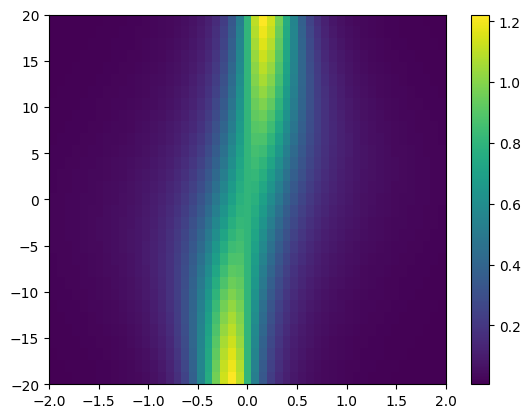

In [56]:
plt.imshow(
    nbars.T,
    extent=(
        deltas_a[0] / MHz,
        deltas_a[-1] / MHz,
        deltas_b[0] / MHz,
        deltas_b[-1] / MHz,
    ),
    aspect="auto",
    origin="lower",
)
print(nbars[len(deltas_a) // 2, len(deltas_b) // 2])
plt.colorbar()

In [98]:
data = np.load("diamond_data_fit_2.npy", allow_pickle=True).item()
w_buf_array = data["buffer_freqs"] * Hz
w_pump_array = data["pump_freqs"] * Hz
nbars = data["nbars"]
t_stab = 10 * us

(41, 51)

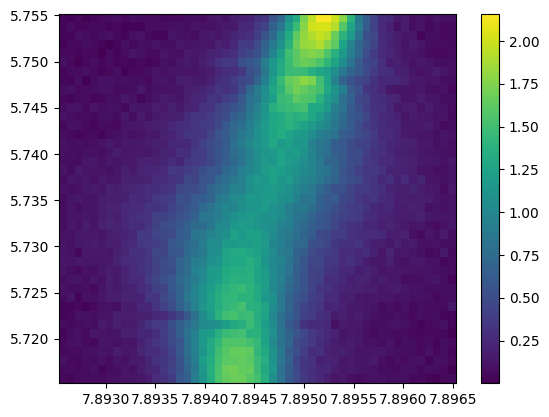

In [99]:
plt.imshow(
    nbars,
    extent=[
        w_buf_array[0] / GHz,
        w_buf_array[-1] / GHz,
        w_pump_array[0] / GHz,
        w_pump_array[-1] / GHz,
    ],
    interpolation="none",
    origin="lower",
    aspect="auto",
)
plt.colorbar()
data["nbars"].shape

In [100]:
def diamond_for_fit(buf_puls, pump_puls, kappa_b, g2, eps_d):
    kerr = 14 * kHz
    kappa_a = 1 / (70 * us)
    global w_buf_array, w_pump_array, t_stab
    delta_a = (w_buf_array - buf_puls) * 2
    delta_b = w_pump_array - pump_puls
    sim_res = simulate_diamond(
        7, 3, delta_a, delta_b, kappa_a, kappa_b, g2, kerr, eps_d, t_stab, 1000
    )
    return sim_res

In [101]:
def square_distance(x):
    global nbars
    sim_res = diamond_for_fit(*x)
    return (sim_res - nbars.T).flatten() ** 2

In [104]:
guess = 7.8945e9 * Hz, 5.735e9 * Hz, 30 * MHz, 3 * MHz, 3 * MHz
res = diamond_for_fit(*guess)

Batch 1/3


|██████████| 100.0% ◆ total 1.31s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.17s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.29s ◆ remaining 00:00


(41, 51)

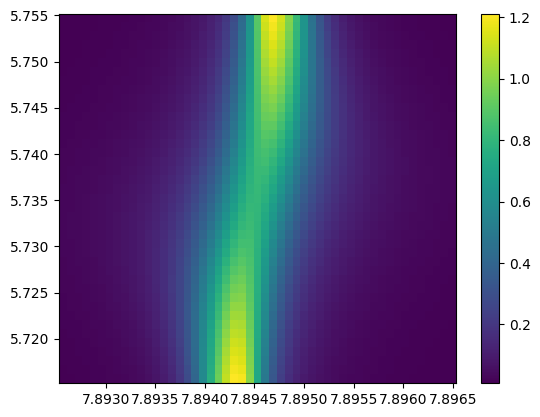

In [105]:
plt.imshow(
    res.reshape(nbars.shape[::-1]).T,
    extent=[
        w_buf_array[0] / GHz,
        w_buf_array[-1] / GHz,
        w_pump_array[0] / GHz,
        w_pump_array[-1] / GHz,
    ],
    interpolation="none",
    origin="lower",
    aspect="auto",
)
plt.colorbar()
data["nbars"].shape

In [106]:
res = least_squares(
    square_distance,
    guess,
    bounds=(
        (w_buf_array[0], w_pump_array[0], 0, 0, 0),
        (w_buf_array[-1], w_pump_array[-1], 100 * MHz, 10 * MHz, 100 * MHz),
    ),
)

Batch 1/3


|██████████| 100.0% ◆ total 1.29s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.17s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.28s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.52s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.40s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.20s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.23s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.22s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.34s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.29s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.17s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.28s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.29s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.16s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.28s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.28s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.17s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.28s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.43s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.45s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.59s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.43s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.43s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.46s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.44s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.45s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.43s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.45s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.43s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.45s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.66s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.53s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.46s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.52s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.51s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.51s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.47s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.51s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.51s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Batch 1/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.48s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


res_fit_for_data 1

array([4.96010434e+04, 3.60355634e+04, 6.28317899e-01, 1.37255689e+02,
       1.81300509e+01, 9.37399409e+01])

array([4.96008993e+04, 3.60336259e+04, 1.72815570e+02, 1.99317763e+01,
       1.03165795e+02])

In [107]:
res.x

array([4.96021041e+04, 3.60423849e+04, 1.82545952e+02, 2.61349997e+01,
       2.98038113e+01])

In [108]:
simul = diamond_for_fit(*res.x)

Batch 1/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 2/3


|██████████| 100.0% ◆ total 1.49s ◆ remaining 00:00


Batch 3/3


|██████████| 100.0% ◆ total 1.50s ◆ remaining 00:00


Text(0.5, 0.98, '$\\kappa_b = 29.05$ MHz, $g_2 = 4.16$ MHz, $\\epsilon_d = 4.74$ MHz')

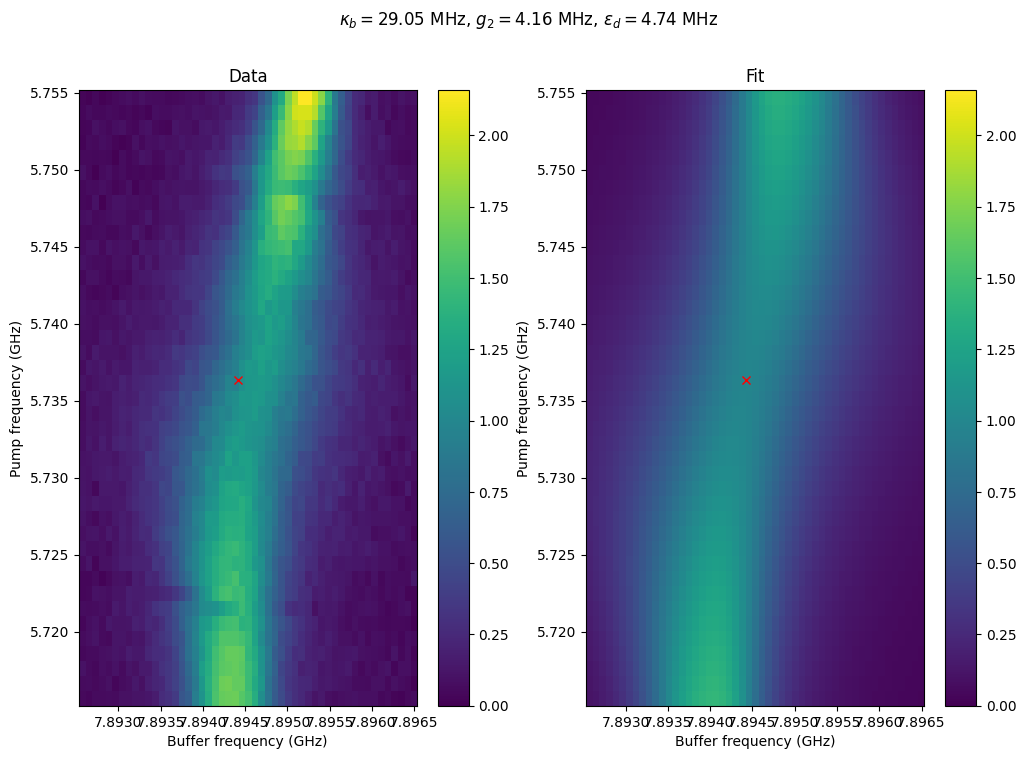

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
extent = [
    w_buf_array[0] / GHz,
    w_buf_array[-1] / GHz,
    w_pump_array[0] / GHz,
    w_pump_array[-1] / GHz,
]
vmax = max(nbars.max(), simul.max())
for a, d, t in zip(ax, [nbars, simul.T], ["Data", "Fit"]):
    im = a.imshow(
        d,
        extent=extent,
        interpolation="none",
        origin="lower",
        vmin=0,
        vmax=vmax,
        aspect="auto",
    )
    fig.colorbar(im, ax=a)
    a.set_xlabel("Buffer frequency (GHz)")
    a.set_ylabel("Pump frequency (GHz)")
    a.set_title(t)
    a.plot(res.x[0] / GHz, res.x[1] / GHz, "rx")
fig.suptitle(
    f"$\\kappa_b = {res.x[2]/MHz:.2f}$ MHz, $g_2 = {res.x[3]/MHz:.2f}$ MHz, $\\epsilon_d = {res.x[4]/MHz:.2f}$ MHz"
)